In [2]:
import warnings

warnings.filterwarnings('ignore')

import os

from tools.modeling.timeserieshyperparamtuner import TimeSeriesHyperParamTuner
from tools.modeling.timeseriesmodeler import TimeSeriesModeler

from nba.common import add_game_log_lag, add_game_log_last_5
import nba.constants as c

from xgboost import XGBRegressor
from hyperopt import hp

import numpy as np
import pandas as pd

import glob
import shap

ROOT_DIR = os.getcwd()[:-17] # verify this points to the root directory of the project


SEED = 1
early_stopping = 50
season = c.SEASON_2022_2023
player_game_log_path = ROOT_DIR + 'data/game_logs/2022-23/player'
player_game_log_csv_files = glob.glob(os.path.join(player_game_log_path, '*.csv'))

log = pd.DataFrame()

ROOT_DIR

'/Users/rmcdevi2/Projects/personal/nba-analysis/'

In [2]:
# Get Data
for f in player_game_log_csv_files:
    df = pd.read_csv(f)
    log = pd.concat([log, df], ignore_index=True)

log.to_csv(ROOT_DIR + '/data/game_logs/2022-23/player_game_log_2022-2023.csv', index=False)
log

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,SEASON,OPP_TEAM_ID
0,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201138,2023-03-29,NYK vs. MIA,W,...,2,0,0,0,1,1,3,-3,2022-23,1.610613e+09
1,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201124,2023-03-27,NYK vs. HOU,W,...,1,1,0,0,0,4,26,11,2022-23,1.610613e+09
2,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201093,2023-03-23,NYK @ ORL,L,...,1,0,2,3,4,5,23,20,2022-23,1.610613e+09
3,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201084,2023-03-22,NYK @ MIA,L,...,4,1,0,1,5,1,15,-6,2022-23,1.610613e+09
4,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201073,2023-03-20,NYK vs. MIN,L,...,4,0,0,0,4,10,57,-6,2022-23,1.610613e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,2022-23,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,22200064,2022-10-26,DEN vs. LAL,W,...,3,4,0,0,3,4,31,28,2022-23,1.610613e+09
1486,2022-23,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,22200051,2022-10-24,DEN @ POR,L,...,1,0,0,0,5,4,9,-10,2022-23,1.610613e+09
1487,2022-23,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,22200035,2022-10-22,DEN vs. OKC,W,...,3,1,1,0,2,7,19,18,2022-23,1.610613e+09
1488,2022-23,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,22200026,2022-10-21,DEN @ GSW,W,...,5,0,0,1,4,10,26,-3,2022-23,1.610613e+09


In [3]:
log[c.GAME_DATE] = pd.to_datetime(log[c.GAME_DATE])
log = add_game_log_last_5(log)
log = add_game_log_lag(log)

log.sort_values(by=[c.GAME_DATE])
log

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,FG_PCT_LAG,FGM_LAG,FGA_LAG,FG3M_LAG,FG3A_LAG,FG3_PCT_LAG,FTM_LAG,FTA_LAG,FT_PCT_LAG,PLUS_MINUS_LAG
498,2022-23,2544,LeBron James,1610612747,LAL,Los Angeles Lakers,22200002,2022-10-18,LAL @ GSW,L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,2022-23,2544,LeBron James,1610612747,LAL,Los Angeles Lakers,22200016,2022-10-20,LAL vs. LAC,L,...,0.462,12.0,26.0,3.0,10.0,0.300,4.0,4.0,1.000,-10.0
496,2022-23,2544,LeBron James,1610612747,LAL,Los Angeles Lakers,22200037,2022-10-23,LAL vs. POR,L,...,0.412,7.0,17.0,2.0,8.0,0.250,4.0,6.0,0.667,-1.0
495,2022-23,2544,LeBron James,1610612747,LAL,Los Angeles Lakers,22200064,2022-10-26,LAL @ DEN,L,...,0.545,12.0,22.0,2.0,9.0,0.222,5.0,7.0,0.714,2.0
494,2022-23,2544,LeBron James,1610612747,LAL,Los Angeles Lakers,22200076,2022-10-28,LAL @ MIN,L,...,0.381,8.0,21.0,2.0,8.0,0.250,1.0,2.0,0.500,-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,2022-23,1631094,Paolo Banchero,1610612753,ORL,Orlando Magic,22201118,2023-03-26,ORL vs. BKN,W,...,0.412,7.0,17.0,2.0,4.0,0.500,5.0,6.0,0.833,-9.0
309,2022-23,1631094,Paolo Banchero,1610612753,ORL,Orlando Magic,22201133,2023-03-28,ORL @ MEM,L,...,0.308,4.0,13.0,1.0,1.0,1.000,2.0,4.0,0.500,11.0
308,2022-23,1631094,Paolo Banchero,1610612753,ORL,Orlando Magic,22201151,2023-03-31,ORL @ WAS,W,...,0.500,9.0,18.0,3.0,7.0,0.429,3.0,6.0,0.500,-4.0
307,2022-23,1631094,Paolo Banchero,1610612753,ORL,Orlando Magic,22201169,2023-04-02,ORL vs. DET,W,...,0.471,8.0,17.0,1.0,3.0,0.333,13.0,14.0,0.929,-1.0


In [4]:
# Preprocess Data
PTS_PREDICTION_MASK = [c.PTS] + c.GAME_LOG_LAST_5_MASK + c.GAME_LOG_LAG_MASK
log = log[PTS_PREDICTION_MASK]
log.dropna()

cats = log.select_dtypes(exclude=np.number).columns.tolist()
for col in cats:
    log[col] = log[col].astype('category')

In [5]:
rmse = {
    'base_model': 0,
    'tuned_model': 0,
}

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'n_estimators': 1000
}

In [6]:
ts_modeler = TimeSeriesModeler(XGBRegressor())
ts_modeler.ts_train(params, log, c.PTS)
rmse['base_model'] = ts_modeler.ts_rmse()

[0]	validation_0-rmse:7.65748	validation_1-rmse:10.33331
[100]	validation_0-rmse:0.00069	validation_1-rmse:11.29479
[200]	validation_0-rmse:0.00069	validation_1-rmse:11.29479
[300]	validation_0-rmse:0.00069	validation_1-rmse:11.29479
[400]	validation_0-rmse:0.00069	validation_1-rmse:11.29479
[500]	validation_0-rmse:0.00069	validation_1-rmse:11.29479
[600]	validation_0-rmse:0.00069	validation_1-rmse:11.29479
[700]	validation_0-rmse:0.00069	validation_1-rmse:11.29479
[800]	validation_0-rmse:0.00069	validation_1-rmse:11.29479
[900]	validation_0-rmse:0.00069	validation_1-rmse:11.29479
[999]	validation_0-rmse:0.00069	validation_1-rmse:11.29479
RSME: 11.29479081908991
[0]	validation_0-rmse:8.46299	validation_1-rmse:9.98683
[100]	validation_0-rmse:0.01126	validation_1-rmse:10.33103
[200]	validation_0-rmse:0.00074	validation_1-rmse:10.33104
[300]	validation_0-rmse:0.00074	validation_1-rmse:10.33104
[400]	validation_0-rmse:0.00074	validation_1-rmse:10.33104
[500]	validation_0-rmse:0.00074	valid

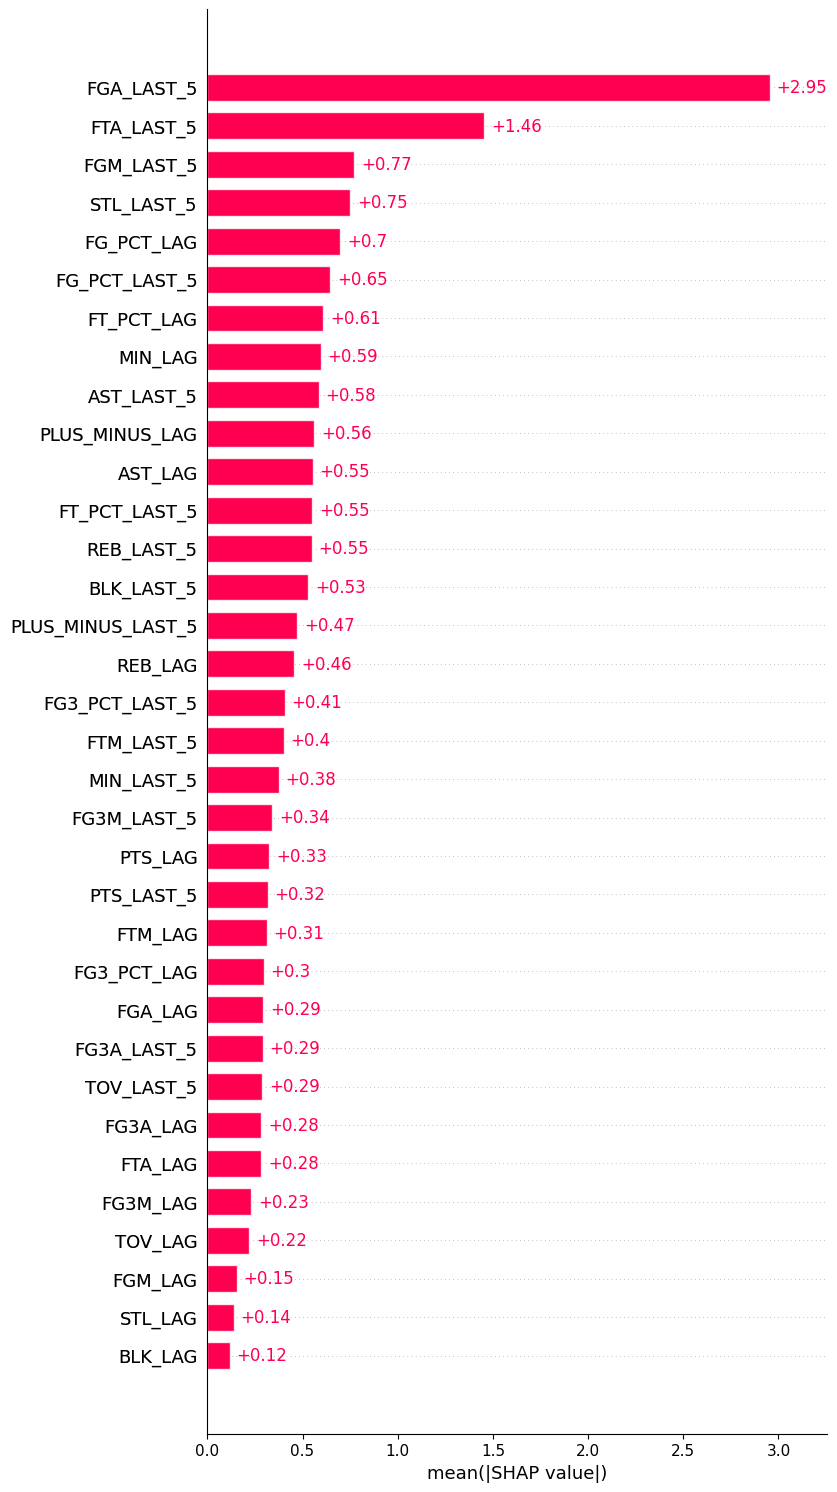

In [7]:
shap.plots.bar(ts_modeler.shap_values(), max_display=100)

In [8]:

space = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': hp.quniform('max_depth', 3, 18, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
}

tuner = TimeSeriesHyperParamTuner(ts_modeler, space)
best = tuner.ts_optimize(250, log, c.PTS)
best

[0]	validation_0-rmse:8.34155	validation_1-rmse:10.34403
[100]	validation_0-rmse:5.83837	validation_1-rmse:10.47813
[200]	validation_0-rmse:5.59850	validation_1-rmse:10.49994
[300]	validation_0-rmse:5.53527	validation_1-rmse:10.51825
[303]	validation_0-rmse:5.53527	validation_1-rmse:10.51825
RSME: 10.518250152308111                               
[0]	validation_0-rmse:8.99110	validation_1-rmse:9.88387
[100]	validation_0-rmse:5.26193	validation_1-rmse:10.28316
[200]	validation_0-rmse:4.80104	validation_1-rmse:10.42470
[300]	validation_0-rmse:4.71625	validation_1-rmse:10.47324
[303]	validation_0-rmse:4.71625	validation_1-rmse:10.47324
RSME: 10.473235459522728                               
[0]	validation_0-rmse:9.16397	validation_1-rmse:9.37774
[100]	validation_0-rmse:4.60108	validation_1-rmse:10.12343
[200]	validation_0-rmse:4.37653	validation_1-rmse:10.15971
[300]	validation_0-rmse:4.22885	validation_1-rmse:10.11197
[303]	validation_0-rmse:4.22885	validation_1-rmse:10.11197
RSME: 10.11

{'colsample_bytree': 0.7951418771893288,
 'eta': 0.5,
 'eval_metric': 'rmse',
 'gamma': 6.916301532337937,
 'max_depth': 5.0,
 'min_child_weight': 10.0,
 'n_estimators': 734.0,
 'objective': 'reg:squarederror',
 'reg_alpha': 168.0,
 'reg_lambda': 0.041934151050167685,
 'subsample': 0.9}

In [9]:
ts_modeler.ts_train(best, log, c.PTS)
rmse['tuned_model'] = ts_modeler.ts_rmse()
rmse

[0]	validation_0-rmse:8.38259	validation_1-rmse:10.16059
[100]	validation_0-rmse:7.39931	validation_1-rmse:10.13344
[200]	validation_0-rmse:7.39931	validation_1-rmse:10.13344
[300]	validation_0-rmse:7.39931	validation_1-rmse:10.13344
[400]	validation_0-rmse:7.39931	validation_1-rmse:10.13344
[500]	validation_0-rmse:7.39931	validation_1-rmse:10.13344
[600]	validation_0-rmse:7.21577	validation_1-rmse:10.11269
[700]	validation_0-rmse:7.21577	validation_1-rmse:10.11269
[733]	validation_0-rmse:7.21577	validation_1-rmse:10.11269
RSME: 10.112685494464788
[0]	validation_0-rmse:9.13797	validation_1-rmse:10.05138
[100]	validation_0-rmse:7.21636	validation_1-rmse:10.18199
[200]	validation_0-rmse:7.21636	validation_1-rmse:10.18199
[300]	validation_0-rmse:7.01540	validation_1-rmse:10.28985
[400]	validation_0-rmse:7.01540	validation_1-rmse:10.28985
[500]	validation_0-rmse:6.87838	validation_1-rmse:10.28782
[600]	validation_0-rmse:6.76571	validation_1-rmse:10.25519
[700]	validation_0-rmse:6.68919	val

{'base_model': 10.292251718696564, 'tuned_model': 9.789546113650559}

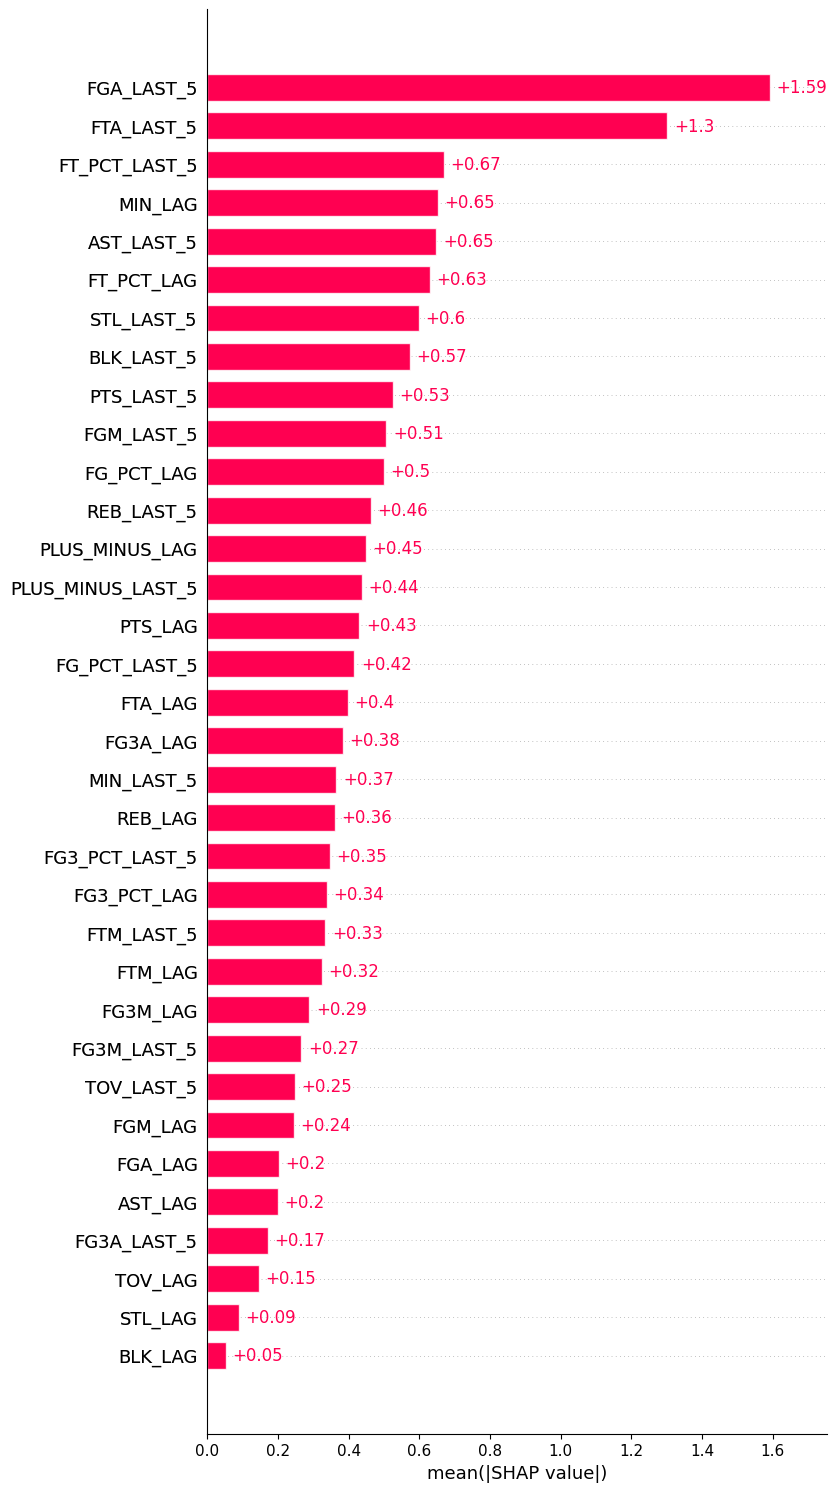

In [10]:
shap.plots.bar(ts_modeler.shap_values(), max_display=100)